# **Recommendation System for Implicit Data & Logistic Matrix Factorization**

---
## Outline:

1. Background
2. Simplified Workflows.
3. Importing Data
4. Data Preparations
5. Data Preprocessing
6. Modeling
7. Hyperparameter Tuning
8. Evaluation
9. Decision Process (Recommendation Process)

# **Background**
---

## Problem Description
---

- Spotify, a Steaming Music Company has a problem with their customer.
- After 3 months from the launch of their previous recommender system, many of the user churn (20%).
- After doing immediate research, they found that user did not consumed what spotify recommending, it means the recommendation is not working good for them

Let say , you are just hired as **Data Scientist / ML Scientist** on Spotify,

## Business Objective
---

Our business objective would be **decreasing user churn 20%** (assumed ofcourse) in 3 months.

## Solution
---


- We can fix previous recommendation algorithm, instead of using star (explicit data) we are gonna use number of plays from user to each artist.

Using number of plays from each user to each artist give meaning to their preference, the more they play it the more confidence we can say, that they are liking those artist

**Our task** is to predict number the preference from each user to each artist

We now have a clearer picture what we should do, However we need more precise solution in recommender system context.

Approach in Personalized Recommender System can be divided based on the presence of interaction data (explicit / implicit) data:     

1. When the interaction data is not exists, the solution that can be implemented is using content feature, **Content Based** Filtering

2. When the interaction data is exists, we can use **Collaborative** Filtering

We can use **Implicit Recommender System** Approach to address this problem.

## Model Metrics
---
We have already established some points :
- Our task is to predict the preference scale (0-1) from users
- We will use Implicit Feedback Recommender System

Regarding those, we need to measure the success of our model ( metrics)

Previously we rely heavily on evaluating how close our predicted rating to what it supposed to be


However, there are lots of Disadvantage, such as :    
1. Predicted ratings does not always correlate with what user what

We need a solution ? Why don't we just give relevant item recommendation

Our focus, is that we want user receive most relevant item since user has limited time to listen to music,
we will use **Precision @ K** as our metrics

## Data Description
---

- The data is obtained from [Heatrec Dataset](https://grouplens.org/datasets/hetrec-2011/)


Only one file we use

**song count data** : `user_artist_play.csv`


|Features|Descriptions|Data Type|
|:--|:--|:--:|
|`userID`|The user ID|`object`|
|`artistID`|artist that user listen to |`int`|
|`weight`|Number of Plays |`int`|


**artist name** : `artist_name.csv`



|Features|Descriptions|Data Type|
|:--|:--|:--:|
|`id`|artist ID|`object`|
|`name`|artist name|`int`|



# **Recommender System Workflow** (Simplified)
---

## <font color='white'>1. Importing Data</font>

```
1. Load the data.
2. Check the shape & type of data.
3. Handle the duplicates data to maintain data validity.
```

## <font color='white'>2.Modelling : Implicit Feedback Recommender</font>

```
1. Creating Utility Matrix
2. Training + Model Selection  :     
    - Alternating least Squares
    - Logistic Matrix Factorization

4. Evaluating Model
  - Precision @ 5

```


## <font color='white'>3. Generating Recommendation / Predictions</font>

```
1. Giving recommendation for user
```

# **1. Importing Data**
---

What do we do?
1. Load the data.
2. Check the shape & type of data.
3. Handle the duplicates data to maintain data validity.

In [1]:
# Load this library
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [3]:
song_play_path = '../data/sample_user_artist.csv'

song_play_data = pd.read_csv(song_play_path,
                          delimiter = ',')

song_play_data.head()

,userID,artistID,weight
0,7,325,599
1,12,191,4259
2,12,344,5489
3,12,519,982
4,15,609,407


## Check data shapes & types

In [4]:
# Check data shapes
song_play_data.shape

(150, 3)

In [5]:
song_play_data.userID.nunique()

99

In [6]:
# Check data types
song_play_data.dtypes

userID      int64
artistID    int64
weight      int64
dtype: object

## Handling duplicates data


We need to check that there is no user ID that rates similar movie ID more than one.

In [7]:
# Check duplicate data
song_play_data.duplicated(subset=['userID', 'artistID']).sum()

0

## Create load function

Finally, we can create load data function

In [8]:
def load_song_data(path):
    """
    Function to load data & remove from duplicates

    Parameters
    ----------
    path : str
        The path of song play  data

    Returns
    -------
    song_play_data : pandas DataFrame
        The sample of song play data
    """
    # Load data
    song_play_data = pd.read_csv(path, delimiter=',')
    print('Original data shape :', song_play_data.shape)


    return song_play_data


In [9]:
# Load rating data
song_play_data = load_song_data(path = song_play_path)

Original data shape : (150, 3)


In [10]:
song_play_data.head()

,userID,artistID,weight
0,7,325,599
1,12,191,4259
2,12,344,5489
3,12,519,982
4,15,609,407


# **2. Modelling**: Implicit Feedback Recommender System
---

## Background
---

## Workflow
---

To create a personalized RecSys, we can follow these steps:

```
1. Data Preparation --> Create utility matrix & Split Train-Test
2. Train recommendation model --> Baseline, Alternating Least Squares, Logistic Matrix Factorization
3. Choosing Best Model
5. Evaluate Final Model
```

## Implementing Model From Scratch
---

#### Data Preparation

##### Mapping User and Item ID

To create mapping, we can simply create dictionary, which stores :    
- UserId to ordered id
```python
user_to_id = {userid : orderedid}
#example
user_to_id = {'ab' : 1}
```
- Ordered id to UserId
```python
user_to_id = {orderedid : userid }
#example
user_to_id = {1 : 'ab' }
```

In [11]:
# mapping user to ordered id
user_to_id = {user : idx for idx,user in enumerate(song_play_data['userID'].unique())}
id_to_user = {idx : user for idx,user in enumerate(song_play_data['userID'].unique())}

In [12]:
# mapping item to ordered id
item_to_id = {item : idx for idx,item in enumerate(song_play_data['artistID'].unique())}
id_to_item = {idx : item for idx,item in enumerate(song_play_data['artistID'].unique())}

In [13]:
mapped_data = song_play_data.copy()
mapped_data['userID'] = mapped_data['userID'].map(user_to_id)
mapped_data['artistID'] = mapped_data['artistID'].map(item_to_id)

In [14]:
mapped_data

,userID,artistID,weight
0,0,0,599
1,1,1,4259
2,1,2,5489
3,1,3,982
4,2,4,407
...,...,...,...
145,97,0,6933
146,97,2,11498
147,97,24,2120
148,98,67,212


Now, we will create function to map the data

In [15]:
def map_data(data, user_column, item_column) :
    """
    Function to map user and item ID for given dataframe

    Paramaters:
    ----------
    data : pandas.DataFrame
        dataframe to be mapped its ID (user and item)

    user_column : string
        user id to be mapped

    item_column : string
        item id to be mapped

    Returns:
    -------
    mapped_data : pandas.DataFrame

    mapping_user: dict
        dictionary contain user_to_id and id_to_user mapping
    mapping_item :
        dictionary contain item_to_id and id_to_item mapping

    """
    # mapping user to ordered id
    user_to_id = {user : idx for idx,user in enumerate(data[user_column].unique())}

    id_to_user = {idx : user for idx,user in enumerate(data[user_column].unique())}

    # mapping item to ordered id
    item_to_id = {item : idx for idx,item in enumerate(data[item_column].unique())}

    id_to_item = {idx : item for idx,item in enumerate(data[item_column].unique())}

    # copy data to avoid overwriting
    mapped_data = data.copy()

    mapped_data[user_column] = mapped_data[user_column].map(user_to_id)
    mapped_data[item_column] = mapped_data[item_column].map(item_to_id)

    # create mapping
    mapping_user = {'user_to_id' : user_to_id,'id_to_user' : id_to_user}
    mapping_item = {'item_to_id' : item_to_id,'id_to_item' : id_to_item}

    return mapped_data,mapping_user,mapping_item

In [16]:
song_playdata_mapped,mapping_user,mapping_item = map_data(data= song_play_data,
                                user_column = 'userID',
                                item_column = 'artistID')
song_playdata_mapped.head()

,userID,artistID,weight
0,0,0,599
1,1,1,4259
2,1,2,5489
3,1,3,982
4,2,4,407


### Alternating Least Squares
---

#### Objective

$$
\text{Objective}= \underset{}{\min}
\left [
 \sum_{u \in U} \sum_{n \in I}(p_{ui}^{(n)} - \hat{p_{ui}}^{(n)})^2
\right ]
$$

with

$$
p_{ui} = \begin{cases}
  1 & r_{ui} > 0 \\
  0 & r_{ui} < 0
\end{cases}
$$
- $r_{ui}$ : Implicit data feedback from user u to item i

Our main goal is to minimize preference error, between true preference - predicted preference


Add term $\cfrac{1}{2}$ (optional), the purpose is to make the derivative more simple

$$
\text{Objective}= \underset{}{\min} \cfrac{1}{2}
\left [
 \sum_{u \in U} \sum_{n \in I}(p_{ui}^{(n)} - \hat{p_{ui}}^{(n)})^2
\right ]
$$


Adding confidence term


$$
\text{Objective}= \underset{}{\min} \cfrac{1}{2}
\left [
 \sum_{u \in U} \sum_{n \in I} c_{ui}(p_{ui}^{(n)} - \hat{p_{ui}}^{(n)})^2
\right ]
$$

- $c_{ui} = 1 + \alpha r_{ui}$



We remember that to predict user preference towards item i is yielded from dot product $x_u . y_i^T$

with  :     
- $x_u$ : User u latent factor
- $y_i$ : Item i latent factor

$$
\text{Objective}= \underset{x^*,y^*}{\min} \cfrac{1}{2}
\left [
 \sum_{u \in U} \sum_{n \in I} c_{ui}(p_{ui} - x_u.y_i^T)^2
\right ]
$$

- $c_{ui} = 1 + \alpha r_{ui}$

Adding Regularization

The purpose of adding regularization is to make our model can avoid overfitting.We can add Ridge Regularization.

- We come to **Final Objective Function** as follow :


$$
\text{Objective}= \underset{x^*,y^*}{\min} \cfrac{1}{2}
\left [
 \sum_{u \in U} \sum_{n \in I} c_{ui}(p_{ui} - x_u.y_i^T)^2
\right ] + \cfrac{\lambda}{2} \sum_{u \in U} \sum_{n \in I} \left[  ||x_u||^2 + ||y_i||^2 \right]
$$

- $c_{ui} = 1 + \alpha r_{ui}$

#### Initialization

There are two parameters in Alternating Least Squares
- $x_u$ : User factor , matrix `<n_users x n_factor>`
- $y_i$ : Item factor , matrix `<n_items x n_factor>`


In [17]:
n_user = song_playdata_mapped.userID.nunique()
n_item = song_playdata_mapped.artistID.nunique()

In [18]:
# set number of latent factor
n_factor = 50

# set seed
np.random.seed(49)

# initialize user and item factor
xu = np.random.normal(0.,1.,size=(n_user,n_factor))
yi = np.random.normal(0.,1.,size=(n_item,n_factor))

# print shape
print('Shape of user factor',xu.shape)
print('Shape of item factor',yi.shape)

Shape of user factor (99, 50)
Shape of item factor (69, 50)


In [19]:
# loss function
from numpy.linalg import norm
def als_loss(p_true,confidence,xu,yi,lambda_regularization) :
    """Function to calculate loss on Alternating Least Squares"""

    original_loss = (1/2)* confidence*((p_true-(xu.dot(yi.T)))**2)
    regularization_loss = (lambda_regularization/2)**(norm(xu)**2 + norm(yi)**2)

    total_loss = original_loss + regularization_loss
    return total_loss

#### Prediction Function

Our prediction is generated from dot product between user and item factor
$$
\begin{align*}
\hat{p_{ui}} = x_u \cdot y_i^T
\end{align*}
$$


In [20]:
def predict(xu,yi):
    """Prediction function for Alternating Least Squares"""
    pred_pui = xu.dot(yi.T)

    return pred_pui

#### Optimization

##### User Factor ($x_u$)
To find user factor we can solve analytically with Alternating Least Squares
$x_u = (Y^T.C^u.Y + \lambda I )^{-1} \cdot (Y^T.C^u.p(u))$

with
- $Y^T$ : Item Factor (Constant) Transposed
- $Y$ : Item Factor (Constant)
- $\lambda I$ : Regularization Term multiply by identity matrix
- $C^u$ : Confidence from user u to all item , diagonal matrix, has shape of `<n_item x n_item>`
- $p(u)$ : preference from user u, contain binary value of preference (0/1) for all item


##### Item Factor ($y_i$)


To find user factor we can solve analytically with Alternating Least Squares
$yi = (X^T.C^i.X + \lambda I )^{-1} \cdot (X^T.C^i.p(i))$

with
- $X^T$ : User Factor (Constant) Transposed
- $X$ : User Factor (Constant)
- $\lambda I$ : Regularization Term multiply by identity matrix
- $C^i$ : Confidence from item i to all user , diagonal matrix, has shape of `<n_user x n_user>`
- $p(i)$ : preference from item i contain binary value of preference (0/1) for all user


##### Optimization Detail

During optimization we are doing by Solving Analytical Way, called **Alternating Least Squares**

In [21]:
# hyperparameter
n_epoch = 3
alpha = 1
lambda_reg = 0.001

Previously Our Utility Matrix is in Form of Number of user play to each artist, However The Alternating Least Squares Model

- $c_{ui} = 1 + \alpha r_{ui}$ have similar size to utility matrix `<n_users,n_items>`
- $
p_{ui} = \begin{cases}
  1 & r_{ui} > 0 \\
  0 & r_{ui} < 0
\end{cases}  
$ have similar size to utility matrix `<n_users,n_items>`

- $r_{ui}$ : Implicit data feedback from user u to item i


In [22]:
P = np.zeros(shape=(n_user,n_item))
C = np.zeros(shape=(n_user,n_item))

In [23]:
# fill both Confidence and preference
for user_id in range(n_user) :
    for item_id in range(n_item) :
        # retrieve true value from our dataframe
        filter_user = song_playdata_mapped['userID']==user_id
        filter_item = song_playdata_mapped['artistID']==item_id

        r_ui = song_playdata_mapped.loc[(filter_user&filter_item),'weight']
        if r_ui.empty :
            r_ui = 0
        else :
            r_ui = r_ui.values[0]

        P[user_id,item_id] = 1 if r_ui > 0 else 0
        c_ui = 1 + alpha*(r_ui)
        C[user_id,item_id] = c_ui

In [24]:
# check the output of Preference matrix after filling the data
P

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [25]:
# check the output of Confidence matrix after filling the data
C

array([[6.0000e+02, 1.0000e+00, 1.0000e+00, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00],
       [1.0000e+00, 4.2600e+03, 5.4900e+03, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00],
       [1.0000e+00, 1.0000e+00, 1.0000e+00, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00],
       ...,
       [1.0000e+00, 1.0000e+00, 1.0000e+00, ..., 1.6600e+02, 1.0000e+00,
        1.0000e+00],
       [6.9340e+03, 1.0000e+00, 1.1499e+04, ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00],
       [1.0000e+00, 1.0000e+00, 1.0000e+00, ..., 1.0000e+00, 2.1300e+02,
        8.8000e+01]])

In Our Alternating Least Squares Model, to find best parameter we do not need to iterate like gradient descent, because we find best parameter analytically through Alternating Least Squares, however we still curious comparison loss before and after finding optimal weight / parameter

In [26]:
from tqdm import tqdm

# create container to add avg loss during each epoch
loss_per_epoch = []

for _ in tqdm(range(n_epoch)) :
    # predict
    pred_pui = np.dot(xu,yi.T)
    # calculate loss (vectorized)
    loss =  (((P - np.dot(xu,yi.T))**2).dot(C.T).sum()) / (2*(n_user*n_item))
    regularization_loss = (lambda_reg / 2)*(norm(xu)**2 + norm(yi)**2)

    total_loss = loss + regularization_loss

    loss_per_epoch.append(total_loss)

    # update user factor parameter
    for user_id in range(n_user) :
        # holding item factor constant = use all item factor
        Yt = yi.T
        Y = yi
        # Confidence for user n_item x n item --> diagonalize C[user_id,:]
        Cu = np.diag(C[user_id,:])
        # inverse component (Y^T C^u Y + \lambda I)
        inv_component = np.dot(yi.T,Cu).dot(yi) + np.eye(n_factor)*lambda_reg
        inv = np.linalg.inv(inv_component)

        # non inverse component Y^T C^u p(u)
        p_u = P[user_id,:]
        non_inverse_component = (Yt).dot(Cu).dot(p_u)

        gradient_xu = inv.dot(non_inverse_component)

        # update xu
        xu[user_id,:] = (gradient_xu)

    for item_id in range(n_item) :
        # holding user factor constant
        Xt = xu.T
        X = xu
        # Confidence for item , <n_user x n_user>
        Ci = np.diag(C.T[item_id,:])
        # inverse component (Y^T C^u Y + \lambda I)
        inv_component = np.dot(Xt,Ci).dot(X) + np.eye(n_factor)*lambda_reg
        inv = np.linalg.inv(inv_component)

        # non inverse component X^T C^i p(i)
        p_i = P.T[item_id,:]
        non_inverse_component = (Xt).dot(Ci).dot(p_i)

        gradient_yi = inv.dot(non_inverse_component)

        # update xu
        yi[item_id,:] =  (gradient_yi)

100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


In [27]:
# check optimized parameter
xu

array([[ 0.01018646, -0.01587455, -0.01052307, ...,  0.0417707 ,
         0.01193571, -0.05091199],
       [ 0.0413182 , -0.04718764, -0.01583278, ..., -0.01942131,
         0.13075696,  0.15918287],
       [ 0.00743091,  0.07881525,  0.0161102 , ...,  0.10976351,
        -0.02992938, -0.02194887],
       ...,
       [-0.02838972, -0.0280652 ,  0.01058166, ..., -0.04582924,
         0.00668671,  0.03542043],
       [ 0.04245437, -0.02852866, -0.04660927, ...,  0.13365577,
         0.0504858 , -0.00871866],
       [ 0.01154349,  0.04739146,  0.01696743, ...,  0.0282243 ,
         0.08266359,  0.04932873]])

In [28]:
# check optimized parameter
yi

array([[ 0.24066613, -0.79313493,  2.35377405, ...,  0.22474517,
        -0.20532423, -1.28316298],
       [-1.43687154, -1.37947515, -1.56762961, ...,  0.93692672,
         0.22011984, -0.67401479],
       [ 0.09705254, -0.25110156,  0.02517918, ...,  0.46950799,
        -0.57925938,  0.29591512],
       ...,
       [-0.55893477,  1.77353728,  0.6004664 , ..., -1.37548306,
         0.99006334,  0.85317887],
       [-0.54655872,  0.63054222,  0.87974532, ..., -0.59757716,
         1.41928795,  1.19264131],
       [-0.54639853,  0.63035741,  0.87948748, ..., -0.59740202,
         1.41887197,  1.19229176]])

#### Object Oriented Code

In [29]:
class AlternatingLeastSquares :
    def __init__(self,n_epoch=10,n_factor=50,alpha=1,lambda_reg=0.01) :
        """Initialize Hyperparameter """
        self.n_epoch = n_epoch
        self.n_factor = n_factor
        self.alpha = 1
        self.lambda_reg = 0.001


    def prepare_confidence_preference(self,data,user_column,item_column,utility_column,n_user,n_item) :
        """
        Function to user and item factor
        Parameters :
        -----------
        data : pandas DataFrame
            utility data
        user_column : string
            user id column name
        item_column : string
            item id column name
        utility_column : string
            explicit / implicit data column name
        n_user : int
          number of user
        n_item : int
          number of item

        Returns :
        --------
        P : numpy matrix,
            Binary Preference user on item (0/1) shape <n_user,n_item>
        C : int
            Confidence from user on item (c_{ui} = 1 + \alpha*r_{ui}) shape <n_user,n_item>
        """
        # assign zero matrix first for later we fill with our available data
        P = np.zeros(shape=(n_user,n_item))
        C = np.zeros(shape=(n_user,n_item))
        # iterate all over user and item

        for user_id in range(n_user) :
          for item_id in range(n_item) :
              # retrieve true value (r_ui) from our dataframe
              filter_user = data[user_column]==user_id
              filter_item = data[item_column]==item_id

              r_ui = song_playdata_mapped.loc[(filter_user&filter_item),utility_column]

              # if empty means --> no observation,
              if r_ui.empty :
                  # due to we use that as negative sample we assign r_ui = 0
                  r_ui = 0
              else :
                  # else we use non zero r_ui
                  r_ui = r_ui.values[0]
              #
              P[user_id,item_id] = 1 if r_ui > 0 else 0
              c_ui = 1 + alpha*(r_ui)
              C[user_id,item_id] = c_ui

        return P,C

    def fit(self,utility_data,user_column,item_column,utility_column) :
        """
        Function to fit utility_data
        Parameters :
        -----------
        utility_data : pandas.DataFrame
            utility_dataframe contain user and item interaction order <userID,itemID,utility_value>
        user_column : string
        item_column : string
        utility_column : string
        Returns :
        --------

        """
        self.utility_data = utility_data
        self.user_column = user_column
        self.item_column = item_column
        self.utility_column = utility_column
        self.n_user = utility_data[user_column].nunique()
        self.n_item = utility_data[item_column].nunique()
        self.P,self.C = self.prepare_confidence_preference(data=utility_data,user_column= user_column, item_column = item_column
                                           ,utility_column= utility_column, n_user = n_user, n_item = n_item)
        # initialize parameter
        xu = np.random.normal(0.,1.,size=(n_user,n_factor))
        yi = np.random.normal(0.,1.,size=(n_item,n_factor))

        # update parameter
        self.loss_per_epoch = []
        for _ in tqdm(range(self.n_epoch)) :

            pred_pui = np.dot(xu,yi.T)
            # calculate loss (vectorized)
            loss =  (((P - np.dot(xu,yi.T))**2).dot(C.T).sum()) / (2*(n_user*n_item))
            regularization_loss = (lambda_reg / 2)*(norm(xu)**2 + norm(yi)**2)

            total_loss = loss + regularization_loss
            # append loss, for plotting
            self.loss_per_epoch.append(total_loss)

            # update user and item factor
            xu,yi = self.update_factor(P= self.P,
                                      C = self.C,
                                      xu = xu,
                                      yi= yi)
        # save optimized user and item factor
        self.xu = xu
        self.yi = yi

    def predict(self,userid,itemid) :
        """
        Function to predict preference on user id and item id level
        Parameters :
        -----------
        userid : int
            mapped user id
        itemid : int
            mapped item id

        Returns :
        --------
        predicted_preference : float
            predicted preference score
        """
        predicted_preference  = self.xu[user_id].dot(self.yi[item_id].T)

        return predicted_preference

    def update_factor(self,P,C,xu,yi) :
        """
        Function to user and item factor
        Parameters :
        -----------
        P : numpy matrix,
            Binary Preference user on item (0/1) shape <n_user,n_item>
        C : int
            Confidence from user on item (c_{ui} = 1 + \alpha*r_{ui}) shape <n_user,n_item>
        xu : numpy matrix,
            User factor , shape <n_user,n_factor>
        yi : numpy matrix,
            Item factor , shape <n_item,n_factor>
        Returns :
        --------
        xu : numpy matrix,
            Optimzed User factor , shape <n_user,n_factor>
        yi : numpy matrix,
            Optimized Item factor , shape <n_item,n_factor>
        """
        # iterate all over user to update user factor
        for user_id in range(self.n_user) :
            # holding item factor constant = use all item factor
            Yt = yi.T
            Y = yi
            # Confidence for user n_item x n item --> diagonalize C[user_id,:]
            Cu = np.diag(C[user_id,:])
            # inverse component (Y^T C^u Y + \lambda I)
            inv_component = np.dot(yi.T,Cu).dot(yi) + np.eye(self.n_factor)*self.lambda_reg
            inv = np.linalg.inv(inv_component)

            # non inverse component Y^T C^u p(u)
            p_u = P[user_id,:]
            non_inverse_component = (Yt).dot(Cu).dot(p_u)

            xu_solution = inv.dot(non_inverse_component)

            # update xu
            xu[user_id,:] = xu_solution

        # iterate all over item , to update item factor
        for item_id in range(self.n_item) :
            # holding user factor constant
            Xt = xu.T
            X = xu
            # Confidence for item , <n_user x n_user> --> diagonalize C.T[item_id,:]
            Ci = np.diag(C.T[item_id,:])
            # inverse component (Y^T C^u Y + \lambda I)
            inv_component = np.dot(Xt,Ci).dot(X) + np.eye(self.n_factor)*self.lambda_reg
            inv = np.linalg.inv(inv_component)

            # non inverse component X^T C^i p(i)
            p_i = P.T[item_id,:]
            non_inverse_component = (Xt).dot(Ci).dot(p_i)

            yi_solution = inv.dot(non_inverse_component)

            # update xu
            yi[item_id,:] =  yi_solution

        return xu,yi

    def plot_loss(self) :
        """Function to plot the loss during training"""
        return plt.plot([x for x in range(self.n_epoch)],self.loss_per_epoch)

In [30]:
als_model = AlternatingLeastSquares()
als_model.fit(utility_data= mapped_data,user_column='userID',
              item_column='artistID',
              utility_column='weight')


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


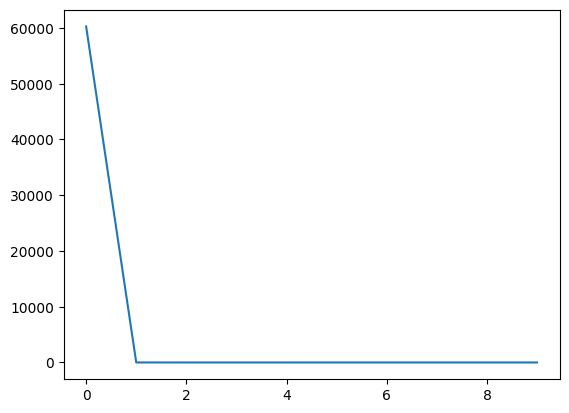

In [31]:
als_model.plot_loss()

We see that because our model is not in iterative manner to find best parameter, instead we use Analytical Solution with Alternating Least Squares

#### Generating Prediction

Let say, we want to predict the preference to user 1 on item 1  

In [32]:
user_target = 1
item_target = 1
pred = als_model.predict(userid= user_target,itemid= item_target)
pred

0.9996879497092995

Now, we can compare to our original data

In [33]:
true_preference = als_model.P

Then, we slice the the preference

In [34]:
true_preference[user_target,item_target]

1.0

We see that our prediction is close enough, now we will evaluate in context of generated prediction using Precision Metrics, the way is simple

#### Evaluating Model

For, easier calculation we will use function to measure **Precision@K**, we are going to use using Precision@5 recommended item

In [35]:
def precision(true_relevant, recommended_items):
    """Function to measure precision from given list of recommendation"""
    # Set a counter
    relevant_item_count = 0

    # Loop all over recommendation list
    for item in recommended_items:
        if item in true_relevant:
            # If in true relevant add 1
            relevant_item_count +=1
        else:
            continue

    # Divide by number of recommended_items
    precision =  relevant_item_count / len(recommended_items)

    return precision

In [36]:
# create empty dictionary to
# loop all over userID
precision_all = np.zeros(mapped_data.userID.nunique() )
n_item_to_recommend = 5

for user in mapped_data.userID.unique() :
    user_recommendation = pd.DataFrame()
    # loop all over artistID
    recommended_artist = []
    artist_score = []
    for artist in mapped_data.artistID.unique() :
        recommended_artist.append(artist)
        preference_score = als_model.predict(userid=user, itemid= artist)
        artist_score.append(preference_score)
    user_recommendation['artist_id'] = recommended_artist
    user_recommendation['score'] = artist_score
    # sort the score
    user_recommendation = user_recommendation.sort_values('score',ascending=False).head(n_item_to_recommend)
    # pick at k highest score
    recommendation = user_recommendation['artist_id'].values.tolist()
    # compare to data in mapped data
    user_true_consumed_item = mapped_data.loc[mapped_data['userID']==user,'artistID'].tolist()

    # we may have item recommended > number of user consumed item
    at_k = min(n_item_to_recommend,len(user_true_consumed_item))

    precision_at_k = precision(true_relevant = user_true_consumed_item[:at_k],
                               recommended_items = recommendation[:at_k])
    # append precision
    precision_all[user] = precision_at_k

avg_precision_atk = np.mean(precision_all)
avg_precision_atk

0.09259259259259259

## Train Recommender System Models
---

### Experiment
---

We want to train all model candidate with its hyperparameter so that we can compare which model + settings yield good result

<img src="../assets/model_training.png">

Since *Hyperparameter* Is not yielded through learning process, we have to find it / set it to yield optimal model performance

Some methods  Hyperparameter Tuning :    

- GridSearchCV

  Fitting model through all combinations of hyperparameter values and compare each fit → which combinations yield the best objective

- RandomizedSearchCV

  Fitting Model only through sampled hyperparameter candidates. Much more efficient than GridSearchCV

- Bayesian Optimization

  Using Bayesian Approach, which include sampling to find best parameter


**Cross Validation** Method

We are going to find the best hyperparameter by comparing sampled parameter combination on validation set

**Hyperparameter Method** : *Bayesian Optimization*


**Model Candidate**

1. Baseline Model
2. Alternating Least Squares
3. Logistic Matrix Factorization

Using Model from Scratch may be benefit for us sometimes, such as getting know to the model inside out the model , however sometimes if we do it from scratch our code is not optimized both in data structure and languannge, since then for training purpose we will use package called [implicit](https://github.com/benfred/implicit)

Install it First

In [37]:
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 5.5 MB/s eta 0:00:00a 0:00:01


#### Load Data

In [41]:
full_data_path = '../data/user_artist_play.csv'

In [42]:
def preprocess_data(song_play_data) :
    """
    Function to preprocess data
    Parameters
    ----------
    song_play_data : pandas.DataFrame
        contain the song_play data

    Returns
    -------
    song_play_data : pandas DataFrame
        The sample of song_play data

    mapping_user : dict
        contain mappers :
        1. user to id
        2. id to user

    mapping_item : dict
        contain mappers :
        1. item to id
        2. id to item

    """
    # copy to avoid overwriting the original dataframe
    song_play_data = song_play_data.copy()
    # mapping step
    # mapping user to ordered id
    user_to_id = {user : idx for idx,user in enumerate(song_play_data['userID'].unique())}
    id_to_user = {idx : user for idx,user in enumerate(song_play_data['userID'].unique())}

    # mapping item to ordered id
    item_to_id = {item : idx for idx,item in enumerate(song_play_data['artistID'].unique())}
    id_to_item = {idx : item for idx,item in enumerate(song_play_data['artistID'].unique())}

    mapping_user = {'user_to_id' : user_to_id,'id_to_user' : id_to_user}
    mapping_item = {'item_to_id' : item_to_id,'id_to_item' : id_to_item}

    song_play_data['userID'] = song_play_data['userID'].map(user_to_id)
    song_play_data['artistID'] = song_play_data['artistID'].map(item_to_id)


    # create utility matrix
    row = song_play_data['userID'].values
    col = song_play_data['artistID'].values
    data = song_play_data['weight'].values


    utility_matrix = sp.coo_matrix((data, (row, col)))
     # return all product(including mapping)
    return utility_matrix, mapping_user,mapping_item

In [43]:
song_data_full = load_song_data(path=full_data_path)
song_utility_matrix,mapping_user,mapping_item = preprocess_data(song_play_data = song_data_full)

Original data shape : (92834, 3)


In [44]:
song_utility_matrix

<1892x17632 sparse matrix of type '<class 'numpy.int64'>'
	with 92834 stored elements in COOrdinate format>

Now, we are going to split the data into Three Subset :  
1. Training 60%
2. Validation 20%
3. Testing 20%

to perform this we can use `implicit.evaluation.train_test_split`

In [45]:
from implicit.evaluation import train_test_split

# split data into train and test
train_full,test = train_test_split(song_utility_matrix,train_percentage=0.8)

# split from train to train and val to make val 20% from all we need to take 25% from training
train,val = train_test_split(train_full,train_percentage=0.75)

/home/daniel/Documents/learning/recommendation_system/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
print('train shape',train.nnz)
print('val shape',val.nnz)
print('test shape',val.nnz)

train shape 55631
val shape 18501
test shape 18501


**Create Model Object**

##### **Baseline Model**

What baseline model do could be based on popular item list

In [47]:
# take most listened artist
n_popular = 5
most_popular_artist = (song_data_full
                       .groupby('artistID')
                       .agg({'weight':'sum'})
                       .sort_values('weight',ascending=False)
                       .head(5)
                       .reset_index()
                       .loc[:,'artistID']).values.tolist()
most_popular_artist

[289, 72, 89, 292, 498]

Measuring Precision @5 for Popular Item

In [48]:
# create empty dictionary to
# loop all over userID
precision_baseline = np.zeros(mapped_data.userID.nunique() )
n_item_to_recommend = 5

for user in mapped_data.userID.unique() :

    user_true_consumed_item = mapped_data.loc[mapped_data['userID']==user,'artistID'].tolist()

    # we may have item recommended > number of user consumed item
    at_k = min(n_item_to_recommend,len(user_true_consumed_item))

    precision_at_k = precision(true_relevant = user_true_consumed_item,
                               recommended_items = most_popular_artist[:at_k])
    # append precision
    precision_all[user] = precision_at_k

avg_precision_baseline = np.mean(precision_all)
avg_precision_baseline

0.0

We can see that our baseline does not give any good performance here..

Since we will be using package called implicit, the package source code is fully optimized and considered fast, we can use full data.

We are going to run Hyperparameter Tuning for each model to know which model are the best , however our package, does not provide the hyperparameter tuning. Why don't we create one. We are going to create RandomizedSearchCV.

So previously, we are only using sampled version of the data, because we are only demonstrating how the model works, and obviously our code is not fully optimized yet (Language and Data Structure).

During model fitting process we will also use Hyperparameter Tuning to find best parameter combination to each model , for that we will use Bayesian Optimization Approach, using Optuna, we need to install it first.

In [49]:
# install optuna
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 5.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.4/597.4 kB 4.4 MB/s eta 0:00:00


##### **Alternating Least Squares**

Hyperparameter :      
- factors : Number of Latent Factor
- regularization : regularization strength
- alpha : for confidence term $c= 1 + \alpha log(1+r_{ui})$


Some candidate value we will use
- factors : `[10,50,100,200,500]`
- regularization : `[0.0001, 0.001, 0.1 , 1.0 ]`
- alpha : `[0.001, 0.1 , 1.0,5.0 ]`

to create hyperparameter tuning, according to optuna documentation, we need to create objective, our goal is to find precision / recall

In [50]:
# for evaluation
from implicit.evaluation import precision_at_k

import optuna

# import model alternating least squares
from implicit import als

def als_tuning(trial):
    factors = trial.suggest_int(name='factors',
                                             low=10,
                                             high=100,step=10)
    regularization = trial.suggest_float(name='regularization',
                                         low=0.0001,
                                         high=1.0,
                                         step= 0.001)

    alpha = trial.suggest_float(name='alpha',
                                      low=0.001,
                                      high=1.0,
                                      step= 0.001)

    # instanciate model
    model_als = als.AlternatingLeastSquares(factors=factors,
                                            regularization= regularization,
                                            alpha= alpha)

    # fit model
    model_als.fit(train)

    # test
    val_metrics = precision_at_k(model = model_als, train_user_items= train,
                                  test_user_items = val,K=5)
    return -val_metrics

# minimizing is equal to
study_als = optuna.create_study(direction="minimize")
study_als.optimize(als_tuning, n_trials=2)

[I 2024-10-09 15:39:58,134] A new study created in memory with name: no-name-b8478eb4-60a5-4efb-99e2-f29dd6b19cdf
/home/daniel/Documents/learning/recommendation_system/.venv/lib/python3.9/site-packages/optuna/distributions.py:689: UserWarning: The distribution is specified by [0.0001, 1.0] and step=0.001, but the range is not divisible by `step`. It will be replaced by [0.0001, 0.9991].
  warnings.warn(
/home/daniel/Documents/learning/recommendation_system/.venv/lib/python3.9/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 1884/1884 [00:00<00:00, 2179.59it/s]
[I 2024-10-09 15:39:59,943] Trial 0 finished with value: -0.11072887551064287 and paramete

In [51]:
#check best parameters and best score
study_als.best_params

{'factors': 90, 'regularization': 0.0961, 'alpha': 0.022000000000000002}

In [52]:
-study_als.best_value

0.17254353902386582

##### **Logistic Matrix Factorization**

Hyperparameter :      
- factors : Number of Latent Factor
- regularization : regularization strength
- learning_rate  : learning rate for gradient update
- neg_prop : number of negative samples to train when having 1 positive items

Some candidate value we will use
- factors : `10 to 500`
- regularization : `0.0001 to  1.0 `
- learning_rate : `0.001 to 1 `
- neg_prop : `10 to 100`

In [53]:
# import model logistic matrix factorization
from implicit import lmf

def lmf_tuning(trial):
    factors = trial.suggest_int(name='factor',
                                             low=10,
                                             high=100,step=10)
    neg_prop = trial.suggest_int(name='neg_prop',
                                             low=10,
                                             high=100,step=10)

    regularization = trial.suggest_float(name='regularization',
                                         low=0.0001,
                                         high=1.0,
                                         step= 0.001)

    learning_rate = trial.suggest_float(name='learning_rate',
                                      low=0.001,
                                      high=1.0,
                                      step= 0.001)

    # instanciate model
    model_lmf = lmf.LogisticMatrixFactorization(factors=factors,
                                            regularization= regularization,
                                            learning_rate= learning_rate,
                                            neg_prop = neg_prop)

    # fit model
    model_lmf.fit(train)

    # test
    val_metrics = precision_at_k(model = model_lmf, train_user_items= train,
                                  test_user_items = val,K=5)
    return -val_metrics

# minimizing is equal to
study_lmf = optuna.create_study(direction="minimize")
study_lmf.optimize(lmf_tuning, n_trials=2)

[I 2024-10-09 15:40:30,338] A new study created in memory with name: no-name-642b75f5-9af2-45ac-879b-d793266f1b7f
100%|██████████| 1884/1884 [00:00<00:00, 2607.69it/s]
[I 2024-10-09 15:40:31,534] Trial 0 finished with value: -0.0074177596215867555 and parameters: {'factor': 10, 'neg_prop': 80, 'regularization': 0.3061, 'learning_rate': 0.8230000000000001}. Best is trial 0 with value: -0.0074177596215867555.
100%|██████████| 1884/1884 [00:00<00:00, 2295.59it/s]
[I 2024-10-09 15:40:35,220] Trial 1 finished with value: -0.004192646742635992 and parameters: {'factor': 90, 'neg_prop': 50, 'regularization': 0.29009999999999997, 'learning_rate': 0.28600000000000003}. Best is trial 0 with value: -0.0074177596215867555.


In [54]:
study_lmf.best_params

{'factor': 10,
 'neg_prop': 80,
 'regularization': 0.3061,
 'learning_rate': 0.8230000000000001}

In [55]:
-1*study_lmf.best_value

0.0074177596215867555

#### **Summary**

After, we run experiment to our model, its better to recap the performance of our model

In [56]:
summary_df = pd.DataFrame({'Model': ['Baseline', 'Alternating Least Squares','Logistic Matrix Factorization'],
                           'CV Performance - Precision @5': [avg_precision_baseline,-1*study_als.best_value,-1*study_lmf.best_value],
                           'Model Condiguration':['N/A',f'{study_als.best_params}',
                                                  f'{study_lmf.best_params}']})

summary_df

,Model,CV Performance - Precision @5,Model Condiguration
0,Baseline,0.000000,N/A
1,Alternating Least Squares,0.172544,"{'factors': 90, 'regularization': 0.0961, 'alp..."
2,Logistic Matrix Factorization,0.007418,"{'factor': 10, 'neg_prop': 80, 'regularization..."


We see that we have alternating Least Squares as our Best Models.

### Training Best Model
---

Now, we will train, our best models, **Alternating Least Squares** on full training data (Train + Val)

In [57]:
# Create object
best_params_als = study_als.best_params
model_best = als.AlternatingLeastSquares(**best_params_als)

# Retrain on whole train dataset
model_best.fit(train_full)

100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


### Evaluate the Best Model
---

#### Evaluate Decision Support Metrics

After finding the best model, we can sanity check the performance on the test dataset.
Next, we predict the test set using our best model, using **Preccision @5**.

In [58]:
test_score = precision_at_k(model = model_best, train_user_items= train_full,
                                  test_user_items = test,K=5)

100%|██████████| 1878/1878 [00:00<00:00, 2486.04it/s]


To summarize

In [59]:
summary_test_df = pd.DataFrame({'Model' : ['Alternating Least Squares'],
                                'Precision@5-Tuning': [-study_als.best_value],
                                'Precision@5': [test_score]})

summary_test_df

,Model,Precision@5-Tuning,Precision@5
0,Alternating Least Squares,0.172544,0.250484


Decision Process is to recommend items to user
from our trained model

# **3.Predictions / Generating Recommendation**
---

How do we generate recommendation ?


To generate recommendation :
- predict all movies or only unseen movies rating from given users
- followed by ordering the movies by its predicted rat

In [60]:
# Recommendation based on Best Models
# We will try to recommend on sample userid ,userId 1 & 99

# We can use model_best.recommend
help(model_best.recommend)

Help on method recommend in module implicit.cpu.matrix_factorization_base:

recommend(userid, user_items, N=10, filter_already_liked_items=True, filter_items=None, recalculate_user=False, items=None) method of implicit.cpu.als.AlternatingLeastSquares instance
    Recommends items for users.
    
    This method allows you to calculate the top N recommendations for a user or
    batch of users. Passing an array of userids instead of a single userid will
    tend to be more efficient, and allows multi-thread processing on the CPU.
    
    This method has options for filtering out items from the results. You can both
    filter out items that have already been liked by the user with the
    filter_already_liked_items parameter, as well as pass in filter_items to filter
    out other items for all users in the batch. By default all items in the training
    dataset are scored, but by setting the 'items' parameter you can restrict down to
    a subset.
    
    Example usage::
    
       

`model_best.recommend` has argument
- `userid` : userID
- `user_items` : Utility matrix for trianing model
- `N=10` : Number of item to recommend
- `filter_already_liked_items` : Whether to recommend seen items or not

### Let's Recommend artist to User 9

In [61]:
user_id = [9]

recommended_artist_id,_ = model_best.recommend(userid= user_id, user_items= train_full[user_id], N=10 )
recommended_artist_id

array([[282, 206,  16, 110, 253, 176, 418, 276, 244, 494]], dtype=int32)

In [62]:
# create dataframe first
recommended_artist_df = pd.DataFrame()
recommended_artist_df['artistID'] = recommended_artist_id[0]
recommended_artist_df['userID'] = 9
recommended_artist_df

,artistID,userID
0,282,9
1,206,9
2,16,9
3,110,9
4,253,9
5,176,9
6,418,9
7,276,9
8,244,9
9,494,9


We already have the recommended artist, however we don't have idea who it is, so we can load artist metadata to find out.

First, we need to map back the `artistID` to original id.

In [63]:
mapping_item.keys()

dict_keys(['item_to_id', 'id_to_item'])

In [64]:
recommended_artist_df['artistID'] = recommended_artist_df['artistID'].map(mapping_item['id_to_item'])
recommended_artist_df

,artistID,userID
0,333,9
1,257,9
2,67,9
3,161,9
4,304,9
5,227,9
6,468,9
7,327,9
8,295,9
9,544,9


Now, we can load the artist metadata

In [65]:
artist_metadata_path = '../data/artist_name.csv'

# read dataframe
artist_name = pd.read_csv(artist_metadata_path)
artist_name.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [66]:
# merge data
recommended_artist_df['artist_name'] = recommended_artist_df.merge(artist_name,right_on='id',left_on='artistID').loc[:,'name']

recommended_artist_df

,artistID,userID,artist_name
0,333,9,Avril Lavigne
1,257,9,Mariah Carey
2,67,9,Madonna
3,161,9,Enrique Iglesias
4,304,9,David Archuleta
5,227,9,The Beatles
6,468,9,Usher
7,327,9,Chris Brown
8,295,9,Beyoncé
9,544,9,Adam Lambert


Now, we can create a function to create recommendation for all users

In [67]:
def recommend_to_users(userid,user_items=train_full,N=10, artist_name = artist_name,
                       mapping_item = mapping_item) :
    # collect user id
    user_id = [userid]
    #
    recommended_artist_id,_ = model_best.recommend(userid= user_id, user_items= train_full[user_id], N=N )

    # create dataframe first
    recommended_artist_df = pd.DataFrame()
    recommended_artist_df['artistID'] = recommended_artist_id[0]
    recommended_artist_df['userID'] = userid


    recommended_artist_df['artistID'] = recommended_artist_df['artistID'].map(mapping_item['id_to_item'])
    # merge data
    recommended_artist_df['artist_name'] = recommended_artist_df.merge(artist_name,
                                                                       right_on='id',left_on='artistID').loc[:,'name']
    return recommended_artist_df

Lets try to recommend to user 100

In [68]:
# recommendation to user 100
recommend_to_users(userid=100)

,artistID,userID,artist_name
0,748,100,Boards of Canada
1,1745,100,Apparat
2,1965,100,Four Tet
3,2605,100,Bonobo
4,1098,100,Björk
5,2691,100,Telefon Tel Aviv
6,1943,100,Flying Lotus
7,4865,100,ISAN
8,7493,100,Luke Vibert
9,767,100,Gridlock


In [69]:
# recommendation to user 1000
recommend_to_users(userid=1000)

,artistID,userID,artist_name
0,65,1000,Coldplay
1,374,1000,宇多田ヒカル
2,378,1000,Evanescence
3,913,1000,Destiny's Child
4,349,1000,The Pussycat Dolls
5,288,1000,Rihanna
6,289,1000,Britney Spears
7,548,1000,Ellie Goulding
8,251,1000,Whitney Houston
9,2094,1000,BoA
